# 프로젝트 설명

- 이번 프로젝트에서는 내일의 날씨를 예측하는 모델을 만들어 보려고 합니다.
- 분류 알고리즘을 통해 비가 온다 or 비가 오지 않는다 의 이진분류 문제로 모델을 만들어 보시기 바랍니다.
- 여러가지 분류 모델을 생성해 보고 가장 높은 정확도를 보이는 모델을 찾아보세요!

# 데이터 설명

호주 기상청에서 10년동안 매일의 날씨를 관측한 데이터입니다.

RainTomorrow 변수가 예측하고 싶은 타겟 변수입니다. - 내일 비가 올까요? 오지 않을까요?   
비가 온다면 Yes, 비가 오지 않는 다면 No로 설정되어 있습니다.  
비가 오는 것의 기준은 강수량이 1mm 이상일 경우입니다.  

---
데이터 변수 설명

- Date : 관측 날짜  
- Location : 관측 장소  
- MinTemp : 최저 온도(섭씨)  
- MaxTemp : 최고 온도(섭씨)  
- Rainfall : 하루 동안 기록된 강우량(mm)  
- Evaporation : 24시간 동안 A급 팬 증발 (9am기준) -> A급 팬이라는 도구로 측정한 증발 양
- Sunshine : 밝은 햇빛이 비치고 있던 시간
- WindGustDir : 24시간 동안 가장 강한 바람이 불었던 방향 (자정기준)
- WindGustSpeed : 24시간 동안 가장 강했던 바람의 속도 (km/h)
- WinDir9am : 오전 9시 바람의 방향
- WinDir3pm : 오후 3시 바람의 방향
- WinSpeed9am : 오전 9시부터 10분간 풍속의 평균
- WinSpeed3pm : 오후 3시부터 10분간 풍속의 평균
- Humidity9am : 오전 9시의 습도
- Humidity3pm : 오후 3시의 습도
- Pressure9am : 평균 해면높이에서 관측된 값으로 환산한 대기압 (오전 9시 기준)
- Pressure3pm : 평균 해면높이에서 관측된 값으로 환산한 대기압 (오후 3시 기준)
- Cloud9am : 하늘이 구름에 가려진 정도, 8개로 구분지어진 "oktas" 단위 활용 (오전 9시 기준)
- Cloud3pm : 하늘이 구름에 가려진 정도, 8개로 구분지어진 "oktas" 단위 활용 (오후 3시 기준)
- Temp9am : 오전 9시의 섭씨 온도 
- Tmep3am : 오후 3시의 섭씨 온도
- RainToday : 오늘 오전 9시까지 24시간동안 1mm이상 강수량이 있었으면 yes, 아니라면 no.
- RainTomorrow : 내일 오전 9시까지 24시간동안 1mm이상 강수량이 있었으면 yes, 아니라면 no. (결과변수)

### 데이터 불러오기

In [45]:
## 필요한 패키지들을 불러오세요.
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from  sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import torch
from torch.utils.data import Dataset
from torch import nn

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

In [3]:
## 주어진 파일명을 활용하여 데이터를 불러와 할당해 보세요. (weatherAUS.csv)
df = pd.read_csv("weatherAUS.csv")
df = df.drop("RISK_MM", axis=1)

In [4]:
## 데이터가 어떻게 생겼는지 5개 정도 row를 출력하여 확인해보세요.
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No



### 데이터 전처리

In [5]:
## 데이터에 결측치가 얼마나 있는지 칼럼별로 확인해 보세요.
print("total number of rows", len(df))
print(df.isnull().sum())

total number of rows 142193
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64


In [6]:
"""
df.columns = 
    Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


"""
cols = df.columns
df['Date'] = pd.to_datetime(df['Date'])

총 데이터 길이 142193
11
Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Temp3pm', 'RainToday',
       'RainTomorrow'],
      dtype='object')


<AxesSubplot:>

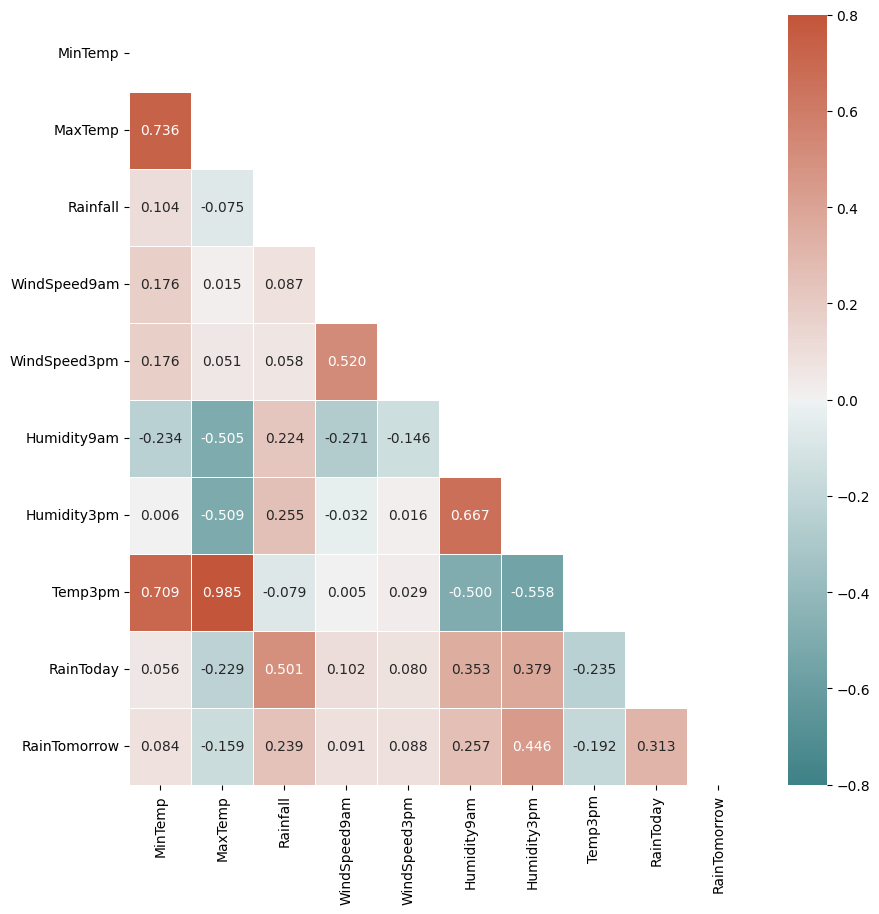

In [7]:
## 데이터가 너무 적은 칼럼과 분석 목표와 무관한 칼럼은 삭제해 보세요.

### Remove rows with missing value on 'RainTomorrow'
df2 = df.dropna(subset=['RainTomorrow']) # RainTomorrow가 NaN인 로우 제거
print("총 데이터 길이", len(df2))

### Remove columns with more than $threshold missing values
threshold_NaN = 5000 # 각 칼럼당 NaN 개수 임계값 / NaN value가 $threshold 이상인 칼럼 삭제
df2.dropna(axis='columns', thresh=len(df)-threshold_NaN, inplace=True)

# Type conversion(Categorical -> Numeric) for EDA 
df2['RainTomorrow'].replace(['No', 'Yes'], [0, 1], inplace=True)
df2['RainToday'].replace(['No', 'Yes'], [0, 1], inplace=True)

df2.drop(labels=['Location', 'WindDir3pm', 'Temp9am'], axis=1, inplace=True)
print(len(df2.columns.tolist()))
print(df2.columns)

# Correlation Analysis
corr = df2.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(200, 20, as_cmap=True)

plt.figure(figsize=(10,10))
sns.heatmap(data=corr, mask=mask, annot=True, fmt='.3f', linewidths=.5, cmap=cmap, vmin=-.8, vmax=.8)



In [8]:
## 결측치를 제거해 보세요.

df3 = df2.set_index('Date') # Convert weather dataset to timeseries
df3.interpolate(method='time', axis=0, inplace=True) # float 자료형 결측치 보정

df3.dropna(axis=0, inplace=True) # Remove missing value of categorical columns
print(df3.isnull().sum())



MinTemp         0
MaxTemp         0
Rainfall        0
WindSpeed9am    0
WindSpeed3pm    0
Humidity9am     0
Humidity3pm     0
Temp3pm         0
RainToday       0
RainTomorrow    0
dtype: int64


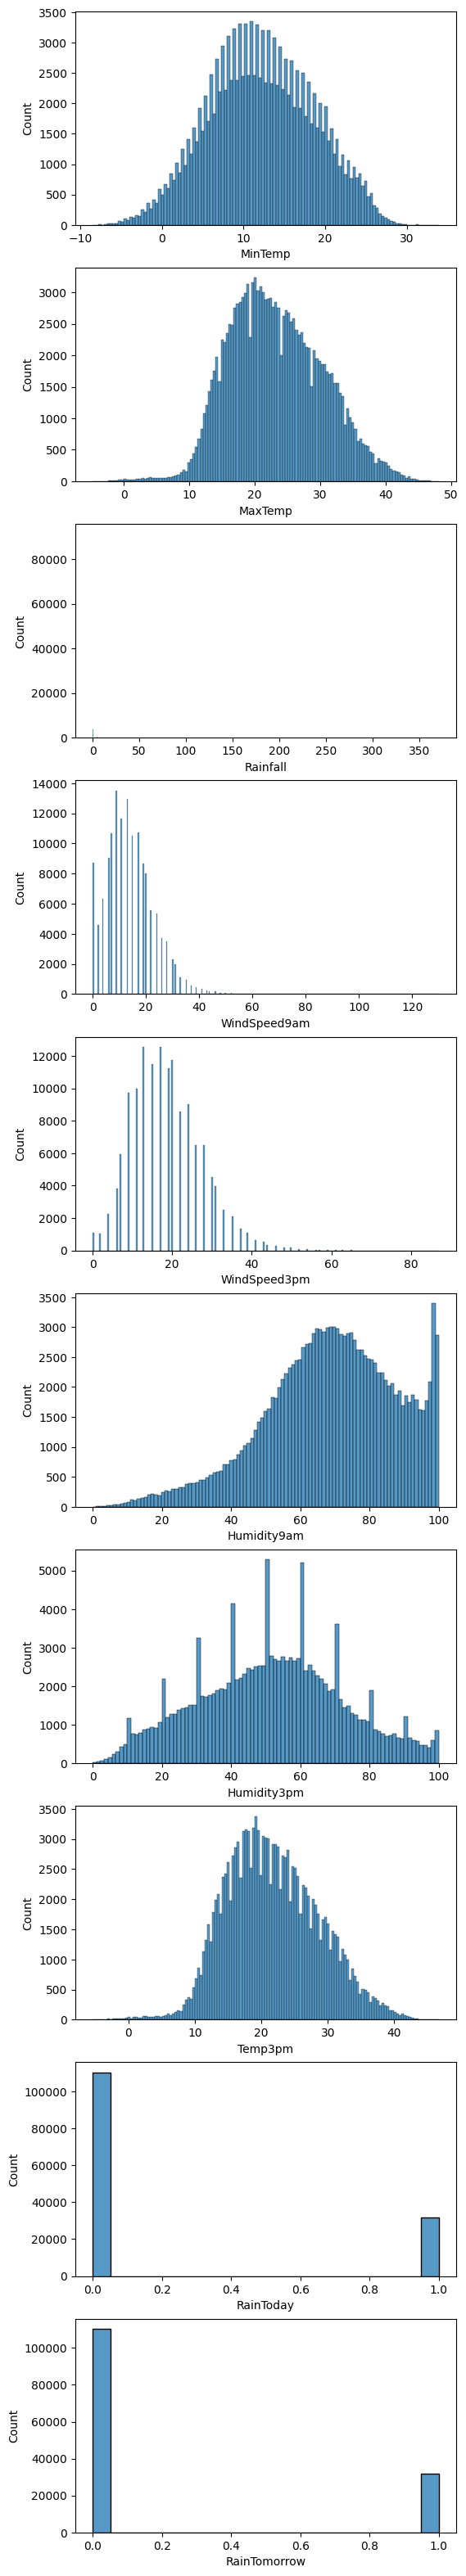

In [9]:
# Data visualization

fig, ax = plt.subplots(nrows=len(df3.columns), figsize=(6, 40))
for idx, col in enumerate(df3.columns):
    sns.histplot(df3[col], ax=ax[idx])


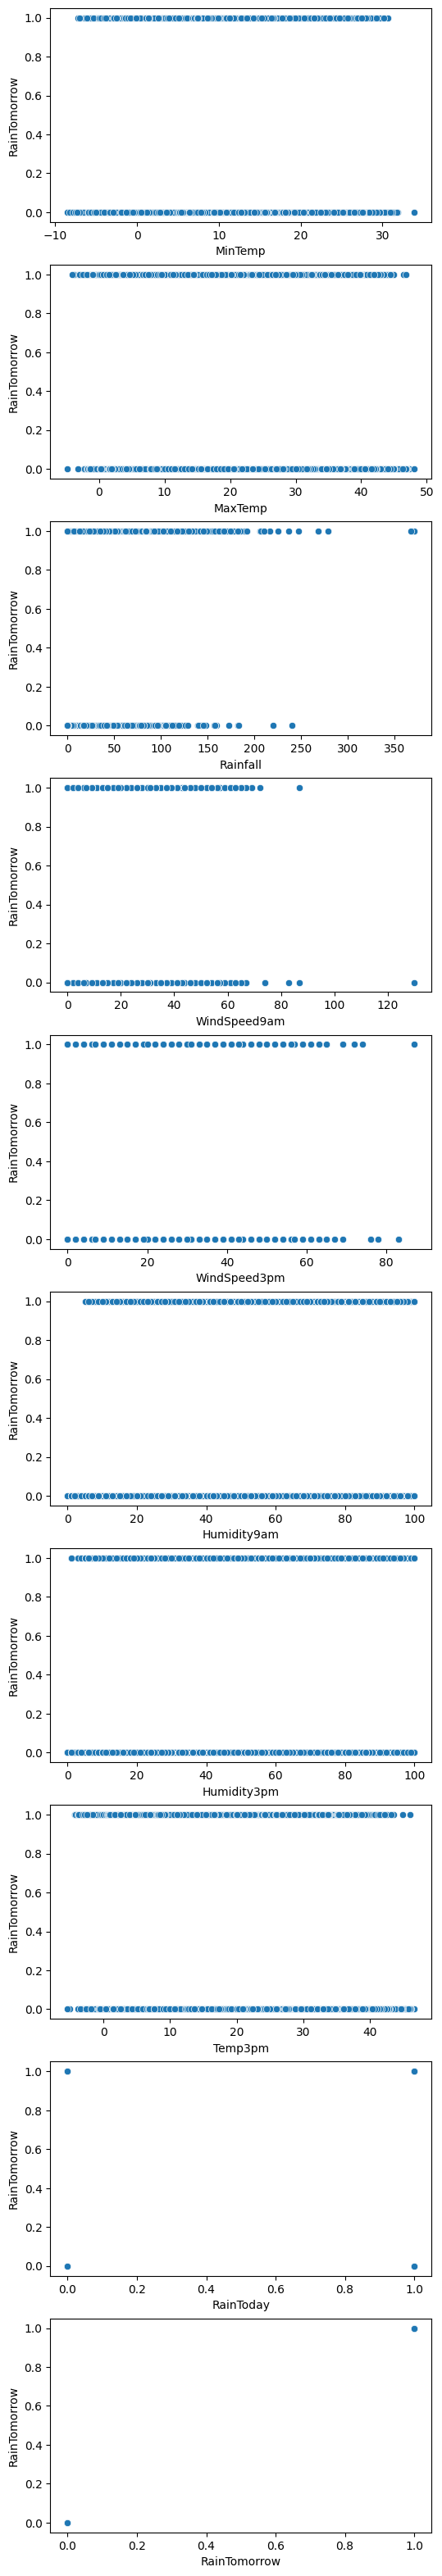

In [10]:
fig, ax = plt.subplots(nrows=len(df3.columns), figsize=(6, 40))
for idx, col in enumerate(df3.columns):
    sns.scatterplot(data=df3, x=str(col), y='RainTomorrow', ax=ax[idx])

In [11]:
## 이상치를 규정하고 제거해보세요.

print(len(df3))

q3 = df3.quantile(0.75)
q1 = df3.quantile(0.25)
iqr = q3 - q1
weight = 2.5

for col in cols:
    if col in ['Rainfall', 'RainToday', 'RainTomorrow']:
        continue
    
    if col in ['MinTemp', 'MaxTemp', 'Temp3pm'] :
        condition = (df3[col] > q3[col] + weight*iqr[col]) | (df3[col] < q1[col] - weight*iqr[col])
        out_idx = df3[condition].index
        df3.drop(out_idx, inplace=True)

    elif col in ['WindSpeed9am', 'WindSpeed3pm'] :
        condition = df3[col] > q3[col] + weight*iqr[col]
        out_idx = df3[condition].index
        df3.drop(out_idx, inplace=True)
    
    elif col in ['Humidity9am', 'Humidity3pm'] :
        condition = df3[col] < q1[col] - weight*iqr[col]
        out_idx = df3[condition].index
        df3.drop(out_idx, inplace=True)

print(len(df3))

142193
126176


In [12]:
## 범주형 칼럼들을 머신러닝에 활용할 수 있게 숫자로 변경해 보세요.

df3['RainToday'].replace(['No', 'Yes'], [0, 1])

Date
2008-12-01    0.0
2008-12-02    0.0
2008-12-03    0.0
2008-12-04    0.0
2008-12-05    0.0
             ... 
2017-06-20    0.0
2017-06-21    0.0
2017-06-22    0.0
2017-06-23    0.0
2017-06-24    0.0
Name: RainToday, Length: 126176, dtype: float64

In [13]:
## 데이터를 스케일링하여 범위를 맞추어 주세요.

min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df3)
print(fitted.data_max_)

df4 = min_max_scaler.transform(df3)
df4 = pd.DataFrame(df4, columns=df3.columns, index=list(df3.index.values))
print(df4.head())

[ 33.9  48.1 371.   48.   50.  100.  100.   46.7   1.    1. ]
             MinTemp   MaxTemp  Rainfall  WindSpeed9am  WindSpeed3pm  \
2008-12-01  0.516509  0.517241  0.001617      0.416667          0.48   
2008-12-02  0.375000  0.559387  0.000000      0.083333          0.44   
2008-12-03  0.504717  0.570881  0.000000      0.395833          0.52   
2008-12-04  0.417453  0.614943  0.000000      0.229167          0.18   
2008-12-05  0.613208  0.697318  0.002695      0.145833          0.40   

            Humidity9am  Humidity3pm   Temp3pm  RainToday  RainTomorrow  
2008-12-01         0.71         0.22  0.519305        0.0           0.0  
2008-12-02         0.44         0.25  0.567568        0.0           0.0  
2008-12-03         0.38         0.30  0.546332        0.0           0.0  
2008-12-04         0.45         0.16  0.610039        0.0           0.0  
2008-12-05         0.82         0.33  0.671815        0.0           0.0  


### 변수선택 

In [16]:
## 모델링에 사용할 변수를 선택해 보세요.

df_final = df4[['Rainfall', 'Humidity9am', 'Humidity3pm', 'RainToday', 'RainTomorrow']]
df_final.head()




,Rainfall,Humidity9am,Humidity3pm,RainToday,RainTomorrow
2008-12-01,0.001617,0.71,0.22,0.0,0.0
2008-12-02,0.000000,0.44,0.25,0.0,0.0
2008-12-03,0.000000,0.38,0.30,0.0,0.0
2008-12-04,0.000000,0.45,0.16,0.0,0.0
2008-12-05,0.002695,0.82,0.33,0.0,0.0


In [23]:
## 예측에 활용할 변수들을 X에, 예측 대상인 RainTomorrow 변수를 y에 할당해 보세요.

X = df_final.drop(['RainTomorrow'], axis=1)
y = df_final['RainTomorrow']

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)


print("X_train's shape : ", X_train.shape)
print("X_test's shape : ", X_test.shape)
print("y_train's shape : ", y_train.shape)
print("y_test's shape : ", y_test.shape)



X_train's shape :  torch.Size([100940, 4])
X_test's shape :  torch.Size([25236, 4])
y_train's shape :  torch.Size([100940])
y_test's shape :  torch.Size([25236])


### 모델생성

In [44]:
## 여러가지 모델을 생성해 보고 Accuracy 기준으로 가장 성능이 좋은 모델을 찾아보세요! 
clf = DecisionTreeClassifier(criterion="gini", random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7995720399429387

In [28]:
## 여러가지 모델을 생성해 보고 Accuracy 기준으로 가장 성능이 좋은 모델을 찾아보세요! 
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)).fit(X_train, y_train)

clf.score(X_test, y_test)




0.8098747820573784

In [24]:
## 여러가지 모델을 생성해 보고 Accuracy 기준으로 가장 성능이 좋은 모델을 찾아보세요! 
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.8330559518148677


In [35]:
## 여러가지 모델을 생성해 보고 Accuracy 기준으로 가장 성능이 좋은 모델을 찾아보세요! 
clf = RidgeClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)


0.8253288952290379

In [39]:
## 여러가지 모델을 생성해 보고 Accuracy 기준으로 가장 성능이 좋은 모델을 찾아보세요! 
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=3000)).fit(X_train, y_train)
clf.score(X_train, y_train)

/home/gmk0904/test_venv/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.8276302754111353